## Import required libaries

In [1]:
pip install camel_tools

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.3/124.3 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 116.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 12.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.9/240.9 kB 20.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 426.6/426.6 kB 38.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 31.8 MB/s eta 0:00:00
  Created wheel for camel-kenlm: filename=camel_kenlm-2023.3.17.2-cp310-cp310-linux_x86_64.whl size=3536794 sha256=8aec7

In [2]:
pip install pyarabic

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.4/126.4 kB 11.7 MB/s eta 0:00:00


In [3]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib.cm as cm


import scipy.sparse
import re
import string
import pyarabic.araby as araby
import nltk
from nltk.corpus import stopwords
import textblob
from textblob import Word
from sklearn import preprocessing

from wordcloud import WordCloud
import camel_tools
import warnings
from camel_tools.utils.dediac import dediac_safebw
from camel_tools.utils.charmap import CharMapper
from camel_tools.utils.transliterate import Transliterator
from sklearn.feature_extraction.text import TfidfVectorizer

## Define Functions for Pre-processing

In [4]:
def remove_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)

In [5]:
def remove_emoji(string):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

In [6]:
def remove_diacritics(text):
    arabic_diacritics = re.compile("""
                             ّ    | # Tashdid
                             َ    | # Fatha
                             ً    | # Tanwin Fath
                             ُ    | # Damma
                             ٌ    | # Tanwin Damm
                             ِ    | # Kasra
                             ٍ    | # Tanwin Kasr
                             ْ    | # Sukun
                             ـ     # Tatwil/Kashida
                         """, re.VERBOSE)
    text = re.sub(arabic_diacritics, '', text)
    text = araby.strip_diacritics(text)
    text = araby.strip_shadda(text)
    text = araby.strip_tashkeel(text)
    return text

The presence of Latin characters will mess with transliteration later on.

so, we should remove them.
also, remove linsk (https), Hashtages and digits.

In [7]:
def remove_non_arabic(text):
    text = re.sub('[%s]' % re.escape("""!"#$%&'()*+,،-./:;<=>؟?@[\]^_`{|}~"""), ' ', text)
    text = re.sub('([@A-Za-z0-9_ـــــــــــــ]+)|[^\w\s]|#|http\S+',' ',text)
    text = re.sub(r'\\u[A-Za-z0-9\\]+',' ',text)
    return text

In [8]:
def remove_repeating_characters(text):
    text = text.strip()
    text = re.sub("[إأٱآا]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ؤ", "ء", text)
    text = re.sub("ئ", "ء", text)
    text = re.sub("ة", "ه", text)
    #text = re.sub(r'(.)\1+', r'\1', text)
    text = re.sub(r'(.)\1{2,}', r'\1\1', text)
    return text

## Read Data

In [9]:
data = pd.read_csv('/content/drive/MyDrive/Data.csv', encoding='utf-8',lineterminator='\n')

In [10]:
data['text'] = data['text'].astype(str)

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147725 entries, 0 to 147724
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   text     147725 non-null  object
 1   dialect  147725 non-null  object
dtypes: object(2)
memory usage: 2.3+ MB


In [12]:
data.shape

(147725, 2)

In [13]:
data.head(20)

,text,dialect
0,@toha_Altomy @gy_yah قليلين ادب ومنافقين. لو ا...,LY
1,@AlmFaisal 😂😂 الليبيين متقلبين!!!\nبس بالنسبة ...,LY
2,@smsm071990 @ALMOGRBE كل 20 تانيه شاب ليبي بير...,LY
3,@AboryPro @lyranoo85 رانيا عقليتك متخلفة. اولا...,LY
4,@lyranoo85 شكلك متعقدة علشان الراجل لي تحبيه ا...,LY
5,@alibobkr63 او حتى من اي دين او طائفة. اسف ممك...,LY
6,@muhamed01111 باهي نستنوه. بلكي مشغول ولا حاجة,LY
7,@muhamed01111 مهما اختلفنا راه نحنا خوت. والله...,LY
8,@muhamed01111 بالنسبة ليا انا والله شبعت هم ون...,LY
9,@Ajo32asLibya @Jed_ly مو نحنا الحياة عندنا مية...,LY


In [14]:
pd.set_option('display.max_colwidth', None)
data.sample(50)

,text,dialect
65392,زي تسجيلات رابعه.... ورجيني.. هههههه\nهو صنف واحد لبن الحمير😄😀😄 #كلنا_مع_السعوديه_ايد_واحده https://t.co/weHlMpIMy0,EG
95939,@PrincessMarioum اه عندك حق فى دى 😂😂😂,EG
121090,@afif_shoman_a خيو محمد قلو أو بتلبس هول التياب أو انت لا خيي ولا بعرفك,LB
66031,@donnaessamm الشمس دي شمسنا والصور دي في مصر 🤔,EG
96727,الضمير لو نام هييجى خازوق فى الحياة يصحيه لكن لو حاجة تانية نامت الحياة هتقفل ابوابها وتروح 😂😂😂 https://t.co/bfGqekZejZ,EG
101195,انا لله انا اليه راجعون .... ادعوا لمحسن بالرحمة و المغفرة https://t.co/5dzKO4fjfj,EG
63137,محتاجين توعيه للناس في كل السوشيال ميديا علشان نحافظ على مرافقنا فيه استهتار وبجاحه في إهدار المال العام وتخريب كل ماهو جديد ونافع https://t.co/469AWs5g1s,EG
5190,@m0hand92 اللهم امين منور يا احبيبي ربي يحفظك,LY
41840,@Biggerthanstan_ معرف انجليزي بس فرنسي,MA
92953,@sonbul_son المرضي بتوعي المخده والمرتبة 😂😂,EG


In [15]:
data['dialect'].value_counts()

EG    57636
LY    36499
LB    27617
SD    14434
MA    11539
Name: dialect, dtype: int64

## Text Pre-processing

- **Removing Punctuations and Symbols**

In [16]:
english_punctuations = string.punctuation
english_punctuations

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [17]:
arabic_punctuations = '''`÷×؛<>_()*&^%][ـ،/:"؟.,'{}~¦+|!”…“–ـ'''
punctuations_list = arabic_punctuations + english_punctuations
punctuations_list

'`÷×؛<>_()*&^%][ـ،/:"؟.,\'{}~¦+|!”…“–ـ!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [18]:
data['text'] = data['text'].apply(remove_punctuations)

- **Remove Emojis**

In [19]:
data['text'] = data['text'].apply(remove_emoji)

- **Stop Words Elimination**

In [20]:
nltk.download('stopwords')
stop=stopwords.words('arabic')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [21]:
data['text'] = data['text'].apply(lambda x:" ".join(x for x in x.split() if x not in stop))

- **Remove Diacritics**

In [22]:
data['text'] = data['text'].apply(remove_diacritics)

- **Remove Non-Arabic Characters**

In [23]:
data['text'] = data['text'].apply(remove_non_arabic)

- **Remove Repeated Characters**

In [24]:
data['text'] = data['text'].apply(remove_repeating_characters)

- **Lemmatisation**

In [25]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [26]:
data['text'] = data['text'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

- **Encoding the Target Classes**

In [27]:
data.dialect.unique()

array(['LY', 'MA', 'EG', 'LB', 'SD'], dtype=object)

In [28]:
#Encoding output labels
encoding = preprocessing.LabelEncoder()

#using fit transform on the data
y = encoding.fit_transform(data.dialect.values)

#replace dialec column with the encoded
data['dialect'] = y

In [29]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147725 entries, 0 to 147724
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   text     147725 non-null  object
 1   dialect  147725 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.3+ MB


In [30]:
data['dialect'].value_counts()

0    57636
2    36499
1    27617
4    14434
3    11539
Name: dialect, dtype: int64

## Saving pre-processed data

In [31]:
data.to_csv('/content/drive/MyDrive/preprocessed_data.csv')

In [32]:
data_cleaned = pd.read_csv('/content/drive/MyDrive/preprocessed_data.csv', lineterminator='\n')

In [33]:
pd.set_option('display.max_colwidth', None)
data_cleaned.sample(50)


,Unnamed: 0,text,dialect
18170,18170,صح تبيلها رجال البيتزا خريجي تورا بورا,2
126984,126984,الكلام الهبل يوجع القلب,1
14647,14647,كورتوا راه فريق هجوم وسط دفاع والمدرب داير سلاطه التشكيله وطبعا معاش نبي نسب بنزيما وبيل خلاص مليت,2
52205,52205,حااضر مليون مساا للناس الكويسه,0
88504,88504,الراجل بتاع الامارات بيقولك ادينا مصر مليار سنتين وتم عمل مشروعات شفافه بيهم علشان كده ماحدش شافهم,0
139466,139466,حسين شيعان مظلوم لازم يرجع اساسي,4
133421,133421,عارفه حاجه انا دغريه بخاف كنتي سالتيني السءال دا مباشره جاتك اجابه مباشره مني سءالك شكل تشكيك يلا انا زاتي عايزه اعرف معاكي بالمناسبه برضو شكوك الحسابات الجديده الاتعملت قريب زي حسابك,4
62784,62784,الرد المتاخر بيخليني اغير الكلام اللي كنت هقولوا بيقتل شغف الكلام جوايا وبيقفلني الشخص وبندم علي اني كلمته اساسا,0
17858,17858,باهي انت اللي فيك جو وجك معش تعرفه ركبه مرفق هه,2
116671,116671,جورج صليبي خفف حكيك خلينا نسمع الجنرال,1


## EDA

In [34]:
#words = [word for tokens in data["text"] for word in tokens]
words = str(data["text"]).split()
sentence_lens = [len(tokens) for tokens in data["text"]]

VOC = sorted(list(set(words)))

print("%s words total, with a vocabulary size of %s" % (len(words), len(VOC)))
print("Max sentence length is %s" % max(sentence_lens))

187 words total, with a vocabulary size of 171
Max sentence length is 276


In [35]:
counter = Counter(words)
counter.most_common(30)

[('دي', 3),
 ('زمان', 2),
 ('يلي', 2),
 ('علشان', 2),
 ('معندهش', 2),
 ('خوت', 2),
 ('متستحقش', 2),
 ('الف', 2),
 ('حساب', 2),
 ('بنت', 2),
 ('البلد', 2),
 ('ديل', 2),
 ('وين', 2),
 ('ياخي', 2),
 ('وراك', 2),
 ('0', 1),
 ('قليلين', 1),
 ('ادب', 1),
 ('ومنافقين', 1),
 ('اختهم', 1),
 ('او', 1),
 ('قريبتهم', 1),
 ('تتعاكس', 1),
 ('تقولي', 1),
 ('عليهم', 1),
 ('نشاط', 1),
 ('حقوق', 1),
 ('المراه', 1),
 ('رده', 1),
 ('فعلهم', 1)]

<BarContainer object of 25 artists>

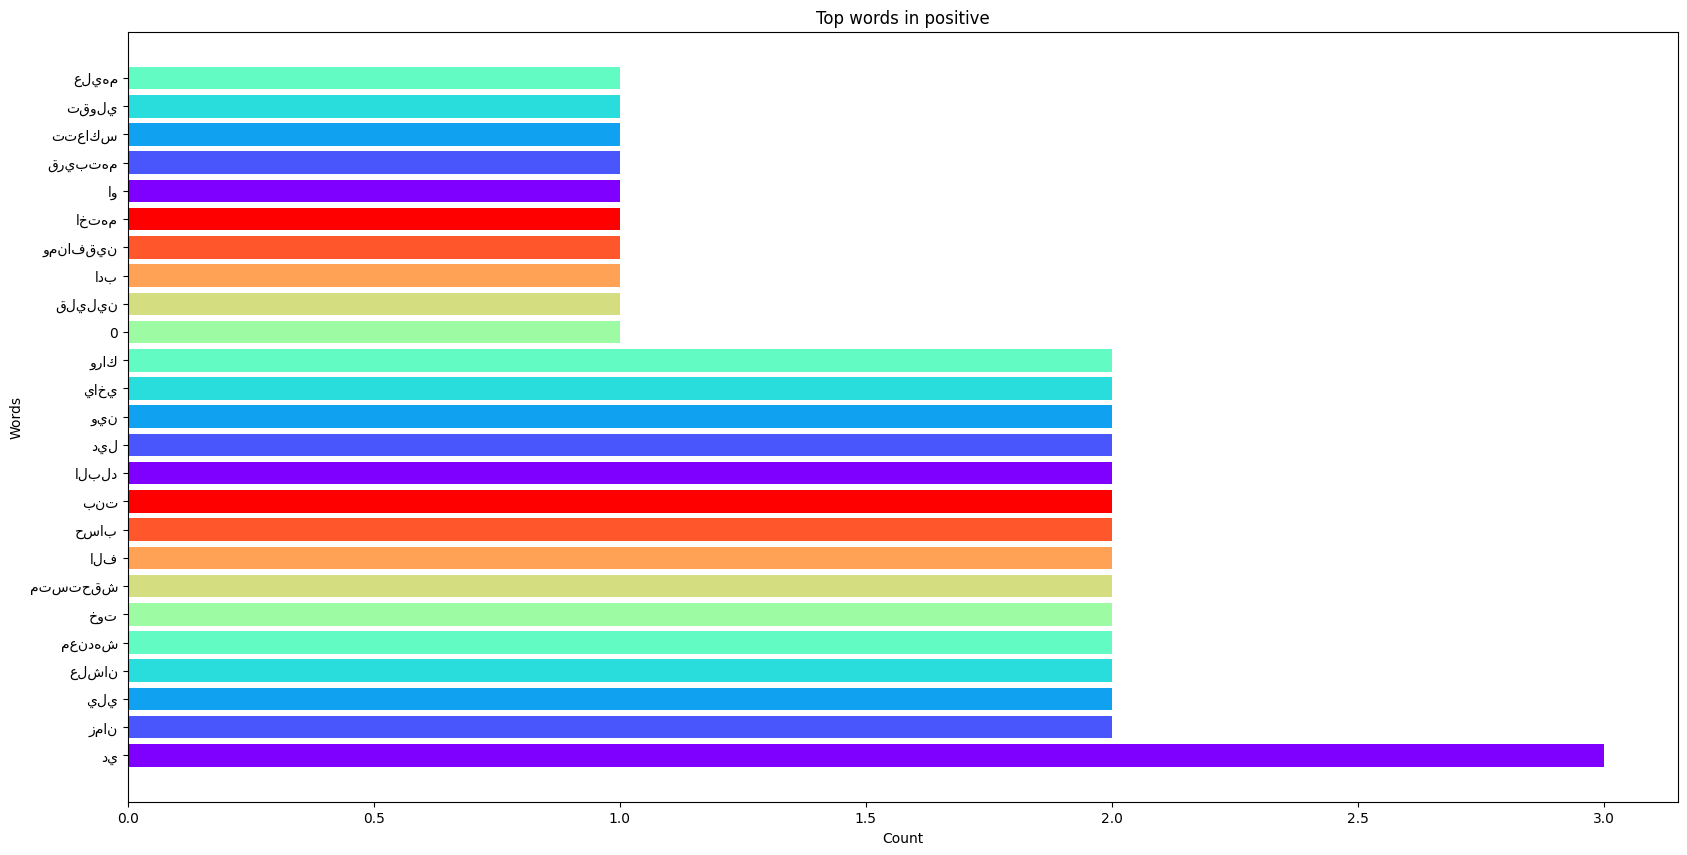

In [36]:
words = []
counts = []
for letter, count in counter.most_common(25):
    words.append(letter)
    counts.append(count)
    
colors = cm.rainbow(np.linspace(0, 1, 10))
plt.rcParams['figure.figsize'] = 20, 10

plt.title('Top words in positive')
plt.xlabel('Count')
plt.ylabel('Words')
plt.barh(words, counts, color=colors)

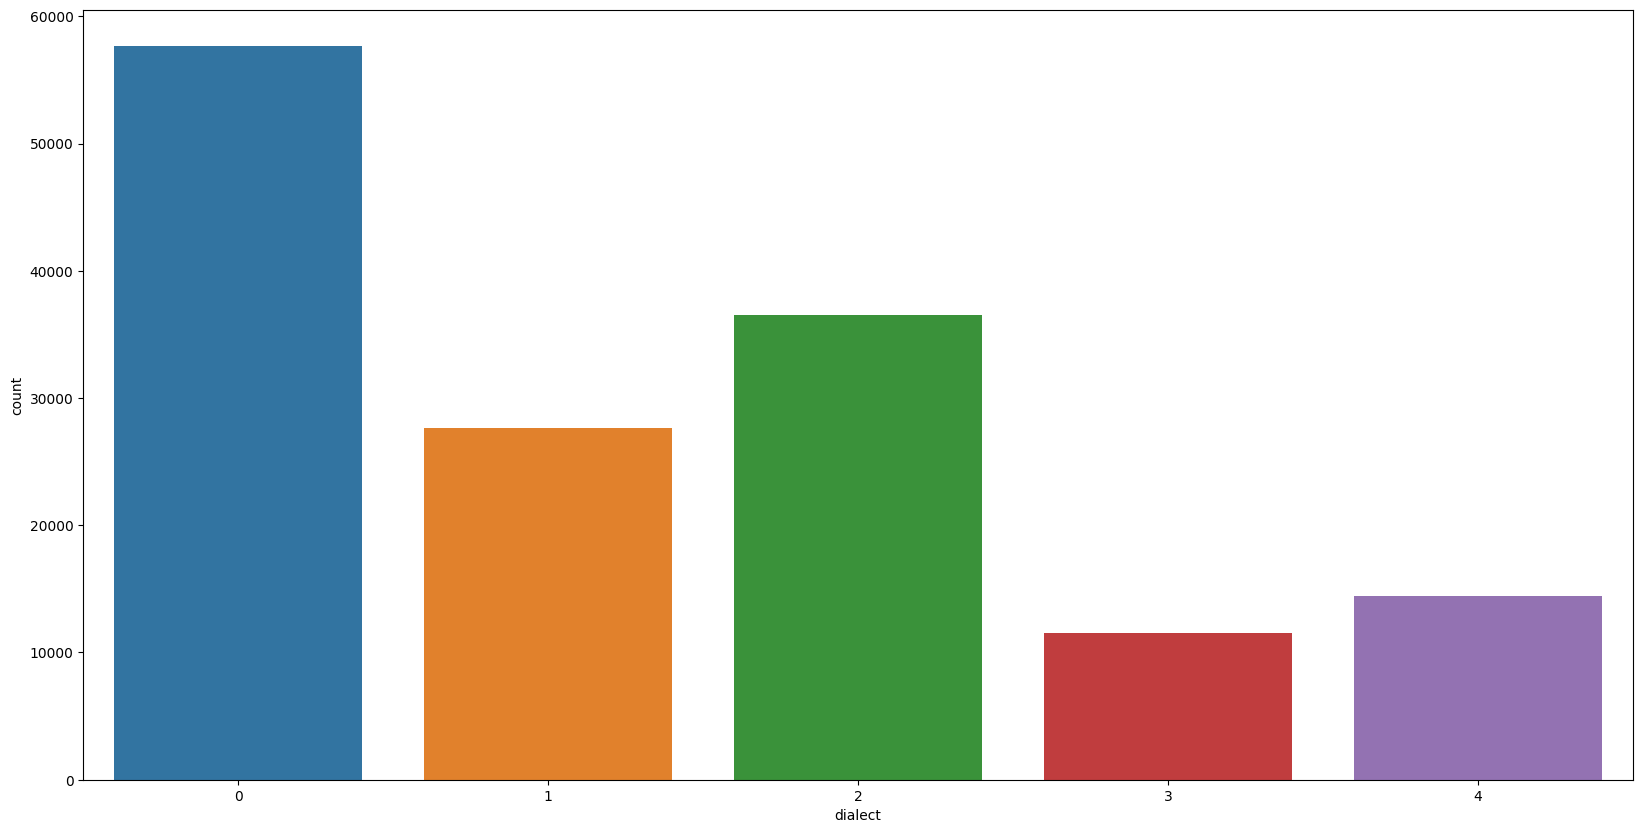

In [37]:
sns.countplot(data= data, x = "dialect")
plt.show()